In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
sample_size = 10000
n_experiments = 1000

sick_prob = 0.01
test_prob_if_sick = 0.999
test_prob_if_healthy = 0.01

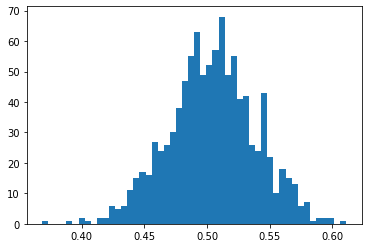

In [3]:
all_probs = []

# each experiment uses sample_size many people.
# in real life, we obviously couldn't repeat the experiment 1000 times (we need new people every time).
# this is just to show how much variance there is between repetitions -- results are unreliable!
# also see what happens when you decrease sample_size.
for experiement_ind in range(n_experiments):
    population_sickness = np.random.rand(sample_size)
    is_sick = population_sickness < sick_prob

    population_tests = np.random.rand(sample_size)
    sick_people = population_tests[is_sick]
    healthy_people = population_tests[np.logical_not(is_sick)]
    
    positive_and_sick = sick_people < test_prob_if_sick
    positive_and_healthy = healthy_people < test_prob_if_healthy
    
    denominator = sum(positive_and_healthy) + sum(positive_and_sick)
    if denominator > 0:
        prob_sick = sum(positive_and_sick) / denominator
    else:
        prob_sick = 0.
        
    all_probs.append(prob_sick)
    
all_probs = np.array(all_probs)

plt.hist(all_probs, bins=50)
plt.show()

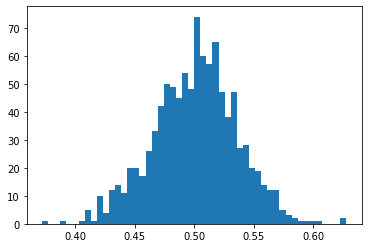

In [4]:
# this is a faster, parallelized version, but it may be harder to understand than the loop above
population_sickness = np.random.rand(n_experiments, sample_size)
is_sick = population_sickness < sick_prob
population_tests = np.random.rand(n_experiments, sample_size)

positive_and_sick = is_sick * (population_tests < test_prob_if_sick)
positive_and_healthy = np.logical_not(is_sick) * (population_tests < test_prob_if_healthy)

denominator = np.sum(positive_and_sick, axis=1) + np.sum(positive_and_healthy, axis=1)

prob_sick = np.sum(positive_and_sick, axis=1) / denominator

plt.hist(prob_sick, bins=50)
plt.show()

In [5]:
# even with 10000 people, we get quite a range of results (about 3% standard deviation)
mean_prob = np.mean(all_probs)
stddev = np.std(all_probs)

print(mean_prob, stddev)

0.5038578352406939 0.034827588719643844


In [6]:
# bayes rule:
# we end up having to compute (0.999*0.01) / (0.999*0.01 + 0.01*0.99)
exact_result = 0.999*0.01 / (0.999*0.01 + 0.01*0.99)
print(exact_result)

0.502262443438914


In [7]:
# conversely, prob of sickness despite negative test:
converse = 0.001*0.01 / (0.001*0.01 + 0.99*0.99)
print(converse)  # very tiny!

1.0202936405097388e-05


In [8]:
# two tests
two_tests = 0.999*0.96*0.01 / (0.999*0.96*0.01 + 0.01*0.02*0.99)

print(two_tests)

0.9797719749908054


In [9]:
# part 2, simple model
avg_time = 10  # = 1/rate
n_people = 10000
samples = np.random.exponential(scale=avg_time, size=n_people)

In [10]:
samples

array([ 2.49867647, 32.26132053,  5.91102003, ...,  1.03250229,
        0.71817671,  2.54156865])

In [16]:
# by derivation, the mean is the optimal scale parameter
samples.mean()

9.909961652442268

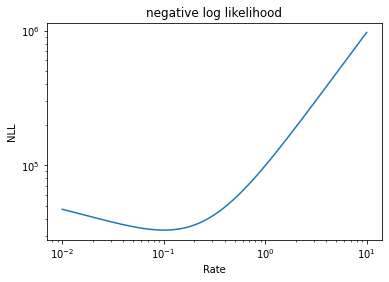

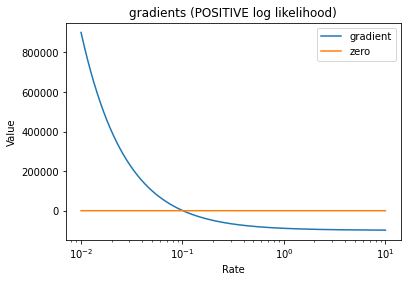

In [13]:
# negative log likelihood as function of lambda, using RATE parameterization
lambda_space = np.geomspace(0.01, 10, 10000)
loglike = n_people*np.log(lambda_space) - lambda_space * samples.sum()
plt.loglog(lambda_space, -loglike)
plt.title("negative log likelihood")
plt.xlabel("Rate")
plt.ylabel("NLL")
plt.show()

gradient = n_people/lambda_space - samples.sum()
plt.semilogx(lambda_space, gradient, label="gradient")
plt.plot(lambda_space, np.zeros_like(lambda_space), label="zero")
plt.title("gradients (POSITIVE log likelihood)")
plt.xlabel("Rate")
plt.ylabel("Value")
plt.legend()
plt.show()

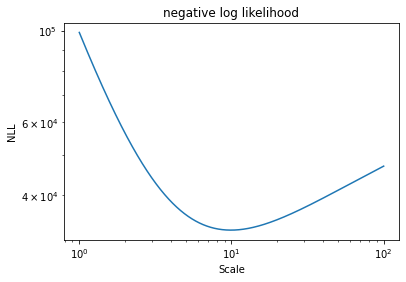

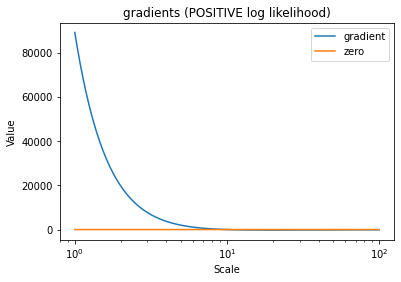

In [14]:
# negative log likelihood as function of lambda, using SCALE parameterization
lambda_space = np.geomspace(1, 100, 10000)
loglike = -n_people*np.log(lambda_space) - 1/lambda_space * samples.sum()
plt.loglog(lambda_space, -loglike)
plt.title("negative log likelihood")
plt.xlabel("Scale")
plt.ylabel("NLL")
plt.show()

gradient = -n_people/lambda_space + 1/lambda_space**2 * samples.sum()
plt.semilogx(lambda_space, gradient, label="gradient")
plt.plot(lambda_space, np.zeros_like(lambda_space), label="zero")
plt.title("gradients (POSITIVE log likelihood)")
plt.xlabel("Scale")
plt.ylabel("Value")
plt.legend()
plt.show()

In [15]:
# could also try gradient descent, slightly overkill...
# unfortunately this is very sensitive to the learning rate!
# in particular, it seems to diverge if lambda ever becomes negative.
# this can happen if it is > than the target value and the gradient reduces it too much at once
# on the other hand, a smaller learning rate might not converge at all (get stuck on the way)
guess_parameter = 1  # some initial value
n_steps = 100
learning_rate = 0.00001

for step in range(1, n_steps+1):
    # this line is for the rate parameterization (what is given e.g. on wikipedia)
    gradient = n_people/guess_parameter - samples.sum()
    
    # this would be fore the scale parameterization (e.g. what numpy uses).
    # this seems to need a higher learning rate
    #gradient = -n_people / guess_parameter + (1/guess_parameter**2)*samples.sum()
    
    # decaying learning rate makes it more stable for higher learning rates
    guess_parameter += learning_rate/step * gradient
    
# we print the expected value (aka mean)
# rate parameterization
print(1/guess_parameter)
# scale parameterization
#print(guess_parameter)

9.909961652442265


In [17]:
# or even with tensorflow!
import os
# do not run this on colab!
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [18]:
import tensorflow as tf

2023-04-20 13:45:40.844215: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-20 13:45:43.136644: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.3/lib64:/scratch/johannsm/python/lib:/usr/local/cuda-11.3/tensorRT-8.0/lib64:/usr/local/cuda-11.3/cudnn-8.2/lib64:/usr/local/cuda-11.3/nccl-2.9/lib64
2023-04-20 13:45:43.136780: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No su

In [19]:
def nll(parameter):  # negative log likelihood
    return - (n_people * tf.math.log(parameter) - parameter * samples.sum())

guess_parameter = tf.Variable(1.)
n_steps = 100
learning_rate = 0.00001

for step in range(1, n_steps + 1):
    with tf.GradientTape() as tape:
        loss = nll(guess_parameter)
    gradient = tape.gradient(loss, guess_parameter)
    
    guess_parameter.assign_sub(learning_rate/step*gradient)
    
print(1/guess_parameter)

tf.Tensor(9.909962, shape=(), dtype=float32)


2023-04-20 13:45:46.691298: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-20 13:45:47.099503: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43644 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:84:00.0, compute capability: 8.6
